In [1]:
import sys
import itertools
import xarray as xr
import numpy as np
import pandas as pd
%matplotlib inline
# import wrf
from matplotlib import cm
import cmocean.cm as cmo
import cmocean

# matplotlib
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.colorbar import Colorbar # different way to handle colorbar
import matplotlib.ticker as mticker
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

# cartopy
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
import cartopy.feature as cfeature

# import personal modules
# Path to modules
sys.path.append('../modules')
# Import my modules
from utils import select_months_ds
from statistical_tests import ttest_1samp_new
from plotter import draw_basemap

In [2]:
path_to_data = '/expanse/nfs/cw3e/cwp140/'
path_to_out  = '../out/'       # output files (numerical results, intermediate datafiles) -- read & write
path_to_figs = '../figs/'      # figures

In [3]:
## load ar dates within region
region = 'gulf_of_mexico' ## 'san_juan' 'baja' 'gulf_of_mexico'
ar_varname = 'ar_scale'
## load ar dates with region (include HUC8 and start date for adding trajectories)
fname = '../out/bbox_dates_{0}_full_{1}.csv'.format(region, ar_varname)
df = pd.read_csv(fname)
df['day'] = pd.to_datetime(df['time']).dt.normalize()

## make a copy of the df but keep only time/index
d = {'datetime': df.day.values}
ar_dates = pd.DataFrame(d)
ar_dates = ar_dates.drop_duplicates(subset=['datetime'])
ar_dates = ar_dates.sort_values(by='datetime')
ar_dates = ar_dates.datetime.values + pd.Timedelta(days=1)
ar_dates


array(['2000-04-28T00:00:00.000000000', '2000-04-29T00:00:00.000000000',
       '2000-10-22T00:00:00.000000000', '2000-10-23T00:00:00.000000000',
       '2000-10-26T00:00:00.000000000', '2000-10-28T00:00:00.000000000',
       '2000-10-29T00:00:00.000000000', '2001-05-03T00:00:00.000000000',
       '2001-05-04T00:00:00.000000000', '2001-06-06T00:00:00.000000000',
       '2001-07-31T00:00:00.000000000', '2002-06-19T00:00:00.000000000',
       '2002-06-20T00:00:00.000000000', '2002-07-04T00:00:00.000000000',
       '2002-07-05T00:00:00.000000000', '2002-08-20T00:00:00.000000000',
       '2002-08-28T00:00:00.000000000', '2002-08-29T00:00:00.000000000',
       '2002-09-08T00:00:00.000000000', '2002-09-09T00:00:00.000000000',
       '2003-03-17T00:00:00.000000000', '2003-03-18T00:00:00.000000000',
       '2003-04-28T00:00:00.000000000', '2003-04-29T00:00:00.000000000',
       '2003-05-14T00:00:00.000000000', '2003-05-15T00:00:00.000000000',
       '2003-05-23T00:00:00.000000000', '2004-04-02

In [4]:
df

,time,lon,traj_lons,lat,traj_lats,level,start_time,HUC8,coord_pair,day
0,2006-06-06 14:00:00,-98.00,-98.109886,26.00,26.053225,719.075177,2006-06-09,14080107,"(26.0, -98.0)",2006-06-06
1,2006-06-06 13:00:00,-98.00,-97.912278,26.00,26.082929,719.289701,2006-06-09,14080107,"(26.0, -98.0)",2006-06-06
2,2006-06-06 12:00:00,-97.75,-97.710885,26.00,26.123538,716.918903,2006-06-09,14080107,"(26.0, -97.75)",2006-06-06
3,2006-06-06 11:00:00,-97.50,-97.518218,26.25,26.164322,713.469645,2006-06-09,14080107,"(26.25, -97.5)",2006-06-06
4,2006-06-06 10:00:00,-97.25,-97.344920,26.25,26.203487,710.540464,2006-06-09,14080107,"(26.25, -97.25)",2006-06-06
...,...,...,...,...,...,...,...,...,...,...
3498,2023-05-09 05:00:00,-94.50,-94.568979,30.50,30.551266,987.207309,2023-05-12,10250013,"(30.5, -94.5)",2023-05-09
3499,2023-05-09 04:00:00,-94.50,-94.464470,30.25,30.365166,990.714632,2023-05-12,10250013,"(30.25, -94.5)",2023-05-09
3500,2023-05-09 03:00:00,-94.25,-94.285386,30.25,30.170943,995.760185,2023-05-12,10250013,"(30.25, -94.25)",2023-05-09
3501,2023-05-09 02:00:00,-94.00,-94.082668,30.00,29.936403,999.074122,2023-05-12,10250013,"(30.0, -94.0)",2023-05-09


In [5]:
## load PRISM watershed precip dataset
fname = path_to_data + 'preprocessed/PRISM/PRISM_HUC8_CO_sp.nc'
PRISM = xr.open_dataset(fname)
HUC8_lst = PRISM.HUC8.values ## get list of HUC8 IDs
    
ds_lst = []
for i, HUC8_ID in enumerate(HUC8_lst):
    fname = path_to_data +'preprocessed/ERA5_trajectories/combined_extreme_AR/PRISM_HUC8_{0}.nc'.format(HUC8_ID)
    traj = xr.open_dataset(fname)
    ds_lst.append(traj)
    
## concat ds_lst along HUC8 index
trajs = xr.concat(ds_lst, pd.Index(HUC8_lst, name="HUC8"))
trajs

<xarray.Dataset>
Dimensions:             (index: 72, start_date: 1641, HUC8: 92)
Coordinates:
  * index               (index) int64 0 1 2 3 4 5 6 7 ... 65 66 67 68 69 70 71
  * start_date          (start_date) datetime64[ns] 2000-01-11 ... 2023-12-26
    time                (HUC8, start_date, index) datetime64[ns] NaT NaT ... NaT
    lon                 (HUC8, start_date, index) float64 nan nan ... nan nan
    lat                 (HUC8, start_date, index) float64 nan nan ... nan nan
  * HUC8                (HUC8) object '14080107' '14080105' ... '10250013'
Data variables: (12/20)
    level               (HUC8, start_date, index) float64 nan nan ... nan nan
    q                   (HUC8, start_date, index) float64 nan nan ... nan nan
    u                   (HUC8, start_date, index) float64 nan nan ... nan nan
    v                   (HUC8, start_date, index) float64 nan nan ... nan nan
    w                   (HUC8, start_date, index) float64 nan nan ... nan nan
    IVT                 (HUC8, start_date, index) float64 nan nan ... nan nan
    ...                  ...
    ar_strict           (HUC8, start_date) float64 nan nan nan ... nan nan nan
    tARget_strict       (HUC8, start_date) float64 nan nan nan ... nan nan nan
    coastal_IVT_strict  (HUC8, start_date) float64 nan nan nan ... nan nan nan
    time_match          (HUC8, start_date) object nan nan nan ... nan nan nan
    lat_match           (HUC8, start_date) float64 nan nan nan ... nan nan nan
    lon_match           (HUC8, start_date) float64 nan nan nan ... nan nan nan

In [6]:
def compute_horizontal_composites(varname, anomaly, ar_dates, ssn, region):
    ## function that computes composites (anomaly or non-anomaly) for defined start_mon and end_mon    
    ## for DJF, MAM, JJA, SON, NDJFMA, and MJJASON
    ## compute anomaly composites - anomaly = True
    ## compute non-anomaly composites - anomaly=False

    ## set start_mon and end_mon based on ssn
    if ssn == 'DJF':
        start_mon, end_mon = (12, 2)
    elif ssn == 'MAM':
        start_mon, end_mon = (3, 5)
    elif ssn == 'JJA':
        start_mon, end_mon = (6, 8)
    elif ssn == 'SON':
        start_mon, end_mon = (9, 11)
    elif ssn == 'NDJFMA':
        start_mon, end_mon = (11, 4)
    elif ssn == 'MJJASO':
        start_mon, end_mon = (5, 10)

    ## load data
    path_to_data = '/expanse/nfs/cw3e/cwp140/downloads/ERA5/'
    out_path = '/home/dnash/DATA/preprocessed/ERA5_composites/'
    
    if anomaly == True:
        fname_pattern = path_to_data + '{0}/anomalies/daily_filtered_anomalies_{0}_*.nc'.format(varname)
    else:
        fname_pattern = path_to_data + '{0}/daily/era5_namerica_025dg_daily_{0}_*.nc'.format(varname)

    ds = xr.open_mfdataset(fname_pattern, engine='netcdf4', combine='by_coords')

    ## subset to AR dates
    ds = ds.sel(time=ar_dates)

    ## subset to start_month and end_month
    ds = select_months_ds(ds, start_mon, end_mon, 'time')
    ds = ds.load()

    # ## run students t-test if anomaly == True
    # if anomaly == True:    
    #     popmean = np.zeros([len(ds.latitude), len(ds.longitude)]) ## population mean
    #     ndays = len(ds.time) # number of unique days
    #     print(ndays)
    #     # calculate t-value based on ndays
    #     a_mean, tval_mask = ttest_1samp_new(a=ds, popmean=popmean, dim='time', n=ndays)

    #     ## write to netCDF
    #     out_fname = out_path + '{0}/{2}/filtered_anomaly_composite_{0}_{1}.nc'.format(varname, ssn, region)
    #     a_mean.to_netcdf(path=out_fname, mode = 'w', format='NETCDF4')

    #     out_fname = out_path + '{0}/{2}/filtered_anomaly_composite_tvals_{0}_{1}.nc'.format(varname, ssn, region)
    #     tval_mask.to_netcdf(path=out_fname, mode = 'w', format='NETCDF4')

    # else:
    #     a_mean = ds.mean('time')
    #     out_fname = out_path + '{0}/{2}/composite_{0}_{1}.nc'.format(varname, ssn, region)
    #     a_mean.to_netcdf(path=out_fname, mode = 'w', format='NETCDF4')

    # return a_mean
    return ds

In [7]:
%%time
## iterate through options
varname_lst = ['700z', 'ivt']
ssn_lst = ['NDJFMA']
anom_lst = [True]

a = [varname_lst, ssn_lst, anom_lst]
ds_lst = []
option_lst = list(itertools.product(*a))
for i, lst in enumerate(option_lst):
    anomaly = lst[2]
    ssn = lst[1]
    varname = lst[0]
    print('Anomaly:', anomaly, 'Season:', ssn, 'Variable:', varname)
    tmp = compute_horizontal_composites(varname, anomaly, ar_dates, ssn, region)
    ds_lst.append(tmp)
ds = xr.merge(ds_lst)
ds

Anomaly: True Season: NDJFMA Variable: 700z
Anomaly: True Season: NDJFMA Variable: ivt
CPU times: user 440 ms, sys: 3.34 s, total: 3.78 s
Wall time: 2min 2s


<xarray.Dataset>
Dimensions:    (longitude: 401, latitude: 201, time: 19)
Coordinates:
  * longitude  (longitude) float32 -170.0 -169.8 -169.5 ... -70.5 -70.25 -70.0
  * latitude   (latitude) float32 60.0 59.75 59.5 59.25 ... 10.5 10.25 10.0
  * time       (time) datetime64[ns] 2000-04-28 2000-04-29 ... 2023-12-13
    dayofyear  (time) int64 119 120 76 77 118 119 93 ... 65 67 111 325 70 347
Data variables:
    z          (time, latitude, longitude) float64 -581.5 -571.8 ... -4.067
    ivtv       (time, latitude, longitude) float64 41.5 40.5 ... 15.13 23.35
    ivtu       (time, latitude, longitude) float64 -66.64 -63.58 ... -54.16
    ivt        (time, latitude, longitude) float64 24.8 21.78 ... 34.34 36.06

In [8]:
## create tick labels 'YYYY-MM-DD HH'
t_lst = []
t_lst2 = []
for m, start_date_val in enumerate(ds.time.values):
    ts = pd.to_datetime(str(start_date_val))
    t = ts.strftime('%Y-%m-%d')
    t_lst.append(t)

    ts = pd.to_datetime(str(start_date_val)) - pd.Timedelta(days=1)
    t = ts.strftime('%Y-%m-%d')
    t_lst2.append(t)
# ["{:.0%}".format(i) for i in cbax.get_ticks()]
t_lst

['2000-04-28',
 '2000-04-29',
 '2003-03-17',
 '2003-03-18',
 '2003-04-28',
 '2003-04-29',
 '2004-04-02',
 '2004-04-03',
 '2007-03-23',
 '2007-03-28',
 '2009-04-15',
 '2009-04-16',
 '2009-04-17',
 '2010-03-06',
 '2010-03-08',
 '2010-04-21',
 '2013-11-21',
 '2019-03-11',
 '2023-12-13']

In [9]:
idx = (df.day == t_lst[2])
df_tmp = df.loc[idx]
len(df_tmp.drop_duplicates(subset=['HUC8', 'start_time']))

2

In [10]:
# Set up projection
# mapcrs = ccrs.Mercator()
mapcrs = ccrs.PlateCarree()
datacrs = ccrs.PlateCarree()
ext = [-140., -90., 20, 50]

# Set tick/grid locations
lats = ds.latitude.values
lons = ds.longitude.values
dx = np.arange(lons.min().round(),lons.max().round()+20,20)
dy = np.arange(lats.min().round(),lats.max().round()+10,10)

# list of letters to append to titles
letter_lst = list(map(chr, range(97, 123)))

-19.51942161217836 10.898834456375951
2


/home/dnash/miniconda3/envs/SEAK-impacts/lib/python3.12/site-packages/shapely/creation.py:119: RuntimeWarning: invalid value encountered in linestrings
  return lib.linestrings(coords, out=out, **kwargs)
/home/dnash/miniconda3/envs/SEAK-impacts/lib/python3.12/site-packages/shapely/creation.py:119: RuntimeWarning: invalid value encountered in linestrings
  return lib.linestrings(coords, out=out, **kwargs)


-23.23816063055977 8.834483441852267
1
-26.4154735949596 12.579320168593695
2


/home/dnash/miniconda3/envs/SEAK-impacts/lib/python3.12/site-packages/shapely/creation.py:119: RuntimeWarning: invalid value encountered in linestrings
  return lib.linestrings(coords, out=out, **kwargs)


-19.59685951440641 17.822694818875352
2


/home/dnash/miniconda3/envs/SEAK-impacts/lib/python3.12/site-packages/shapely/creation.py:119: RuntimeWarning: invalid value encountered in linestrings
  return lib.linestrings(coords, out=out, **kwargs)


-21.179728461598287 17.33538550649917
1
-17.222714649651998 18.230555010172292
1
-18.8122919317141 18.368216633436244
4
-18.36632569731876 17.22242141900346
2
-23.286396825544394 12.519571054340902
4


/home/dnash/miniconda3/envs/SEAK-impacts/lib/python3.12/site-packages/shapely/creation.py:119: RuntimeWarning: invalid value encountered in linestrings
  return lib.linestrings(coords, out=out, **kwargs)
/home/dnash/miniconda3/envs/SEAK-impacts/lib/python3.12/site-packages/shapely/creation.py:119: RuntimeWarning: invalid value encountered in linestrings
  return lib.linestrings(coords, out=out, **kwargs)
/home/dnash/miniconda3/envs/SEAK-impacts/lib/python3.12/site-packages/shapely/creation.py:119: RuntimeWarning: invalid value encountered in linestrings
  return lib.linestrings(coords, out=out, **kwargs)


-13.99837549987367 22.453236985285578
1


/home/dnash/miniconda3/envs/SEAK-impacts/lib/python3.12/site-packages/shapely/creation.py:119: RuntimeWarning: invalid value encountered in linestrings
  return lib.linestrings(coords, out=out, **kwargs)


-18.0268140836913 16.56200123549723
1
-17.741395136670082 17.993997373084156
2
-11.188772453661311 17.922221780105335
2
-22.34321399290608 17.66874292991243
1
-27.557181126184553 14.807472047722419
1


/home/dnash/miniconda3/envs/SEAK-impacts/lib/python3.12/site-packages/shapely/creation.py:119: RuntimeWarning: invalid value encountered in linestrings
  return lib.linestrings(coords, out=out, **kwargs)


-17.025511675838175 12.113653013447777
2
-13.405207156146261 17.379591431420874
1
-19.609712913369567 11.342296788437551
1
-26.51336324020887 15.590708954826727
1


/home/dnash/miniconda3/envs/SEAK-impacts/lib/python3.12/site-packages/shapely/creation.py:119: RuntimeWarning: invalid value encountered in linestrings
  return lib.linestrings(coords, out=out, **kwargs)


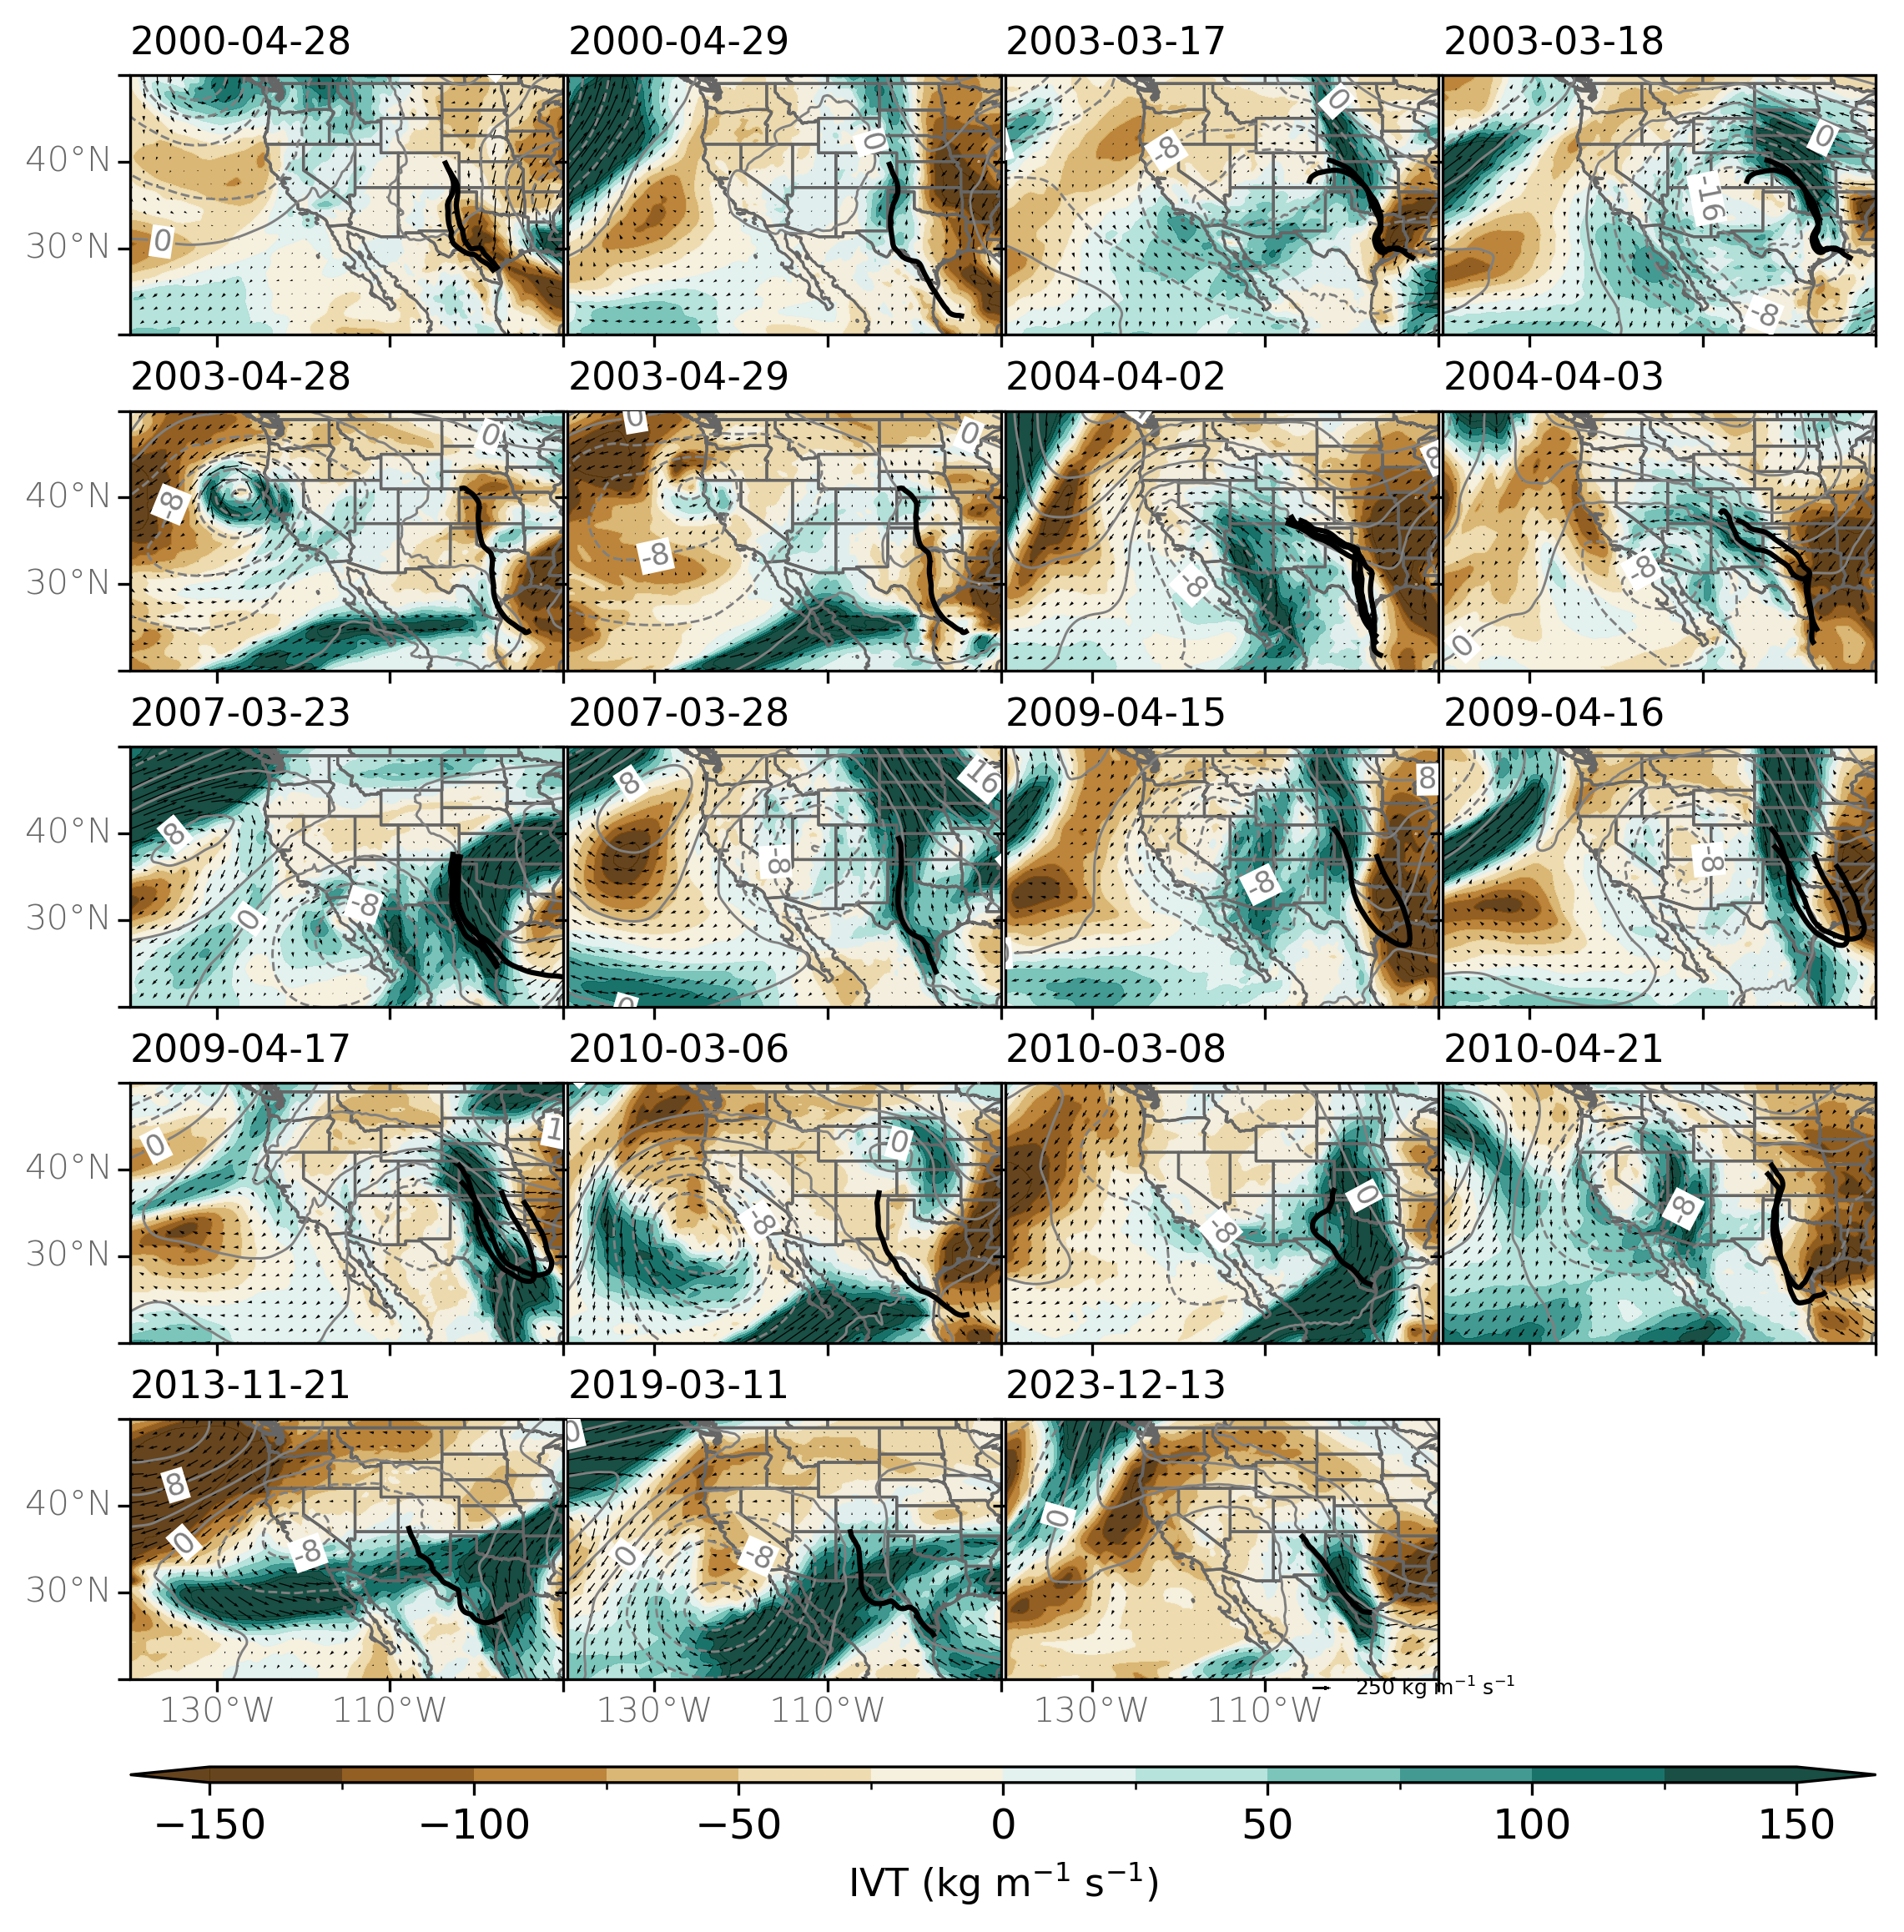

In [11]:
##### Create figure
fig = plt.figure(figsize=(9, 9))
fig.dpi = 300
fname = path_to_figs + '{0}_IVT_700z_synoptic_test_{1}'.format(region, anom_lst[0])
fmt = 'png'

# contour labels
kw_clabels = {'fontsize': 7, 'inline': True, 'inline_spacing': 7, 'fmt': '%i',
              'rightside_up': True, 'use_clabeltext': True}

nrows = 7
ncols = 4

## Use gridspec to set up a plot with a series of subplots that is
## n-rows by n-columns
gs = GridSpec(nrows, ncols, height_ratios=[1, 1, 1, 1, 1, 0.05, 0.05], width_ratios = [1, 1, 1, 1], wspace=0.01, hspace=0.1)
## use gs[rows index, columns index] to access grids

#################
### COMPOSITE ###
#################

rowidx = [0]*4 + [1]*4 + [2]*4 + [3]*4 + [4]*4
colidx = [0, 1, 2, 3]*5
llats = [True, False, False, False]*5
blons = [False, False, False, False]*4 + [True, True, True, True]
# rowidx = [0]*3
# colidx = [0, 1, 2]
# llats = [True, False, False]
# blons = [True, True, True]
for i, (row, col) in enumerate(zip(rowidx[:-1], colidx[:-1])):
    tmp = ds.sel(time=t_lst[i])
    ax = fig.add_subplot(gs[row, col], projection=mapcrs)
    ax = draw_basemap(ax, extent=ext, xticks=dx, yticks=dy, left_lats=llats[i], right_lats=False, bottom_lons=blons[i])
    ax.add_feature(cfeature.STATES, edgecolor='0.4', linewidth=0.8)
    
    # Contour Filled
    lats = tmp.latitude.values
    lons = tmp.longitude.values
    ivt = tmp.ivt.values
    if anom_lst[0] == False:
        cflevs = np.arange(100, 450, 50) # levels for IVT
        cmap = cmo.deep # cmap for IVT
        clevs = np.arange(0, 1280, 4) # levels for 700z
        extend = 'max'
    elif anom_lst[0] == True:
        cmap = cm.BrBG
        cflevs = np.arange(-150., 175., 25)
        clevs = np.arange(-48, 52, 4)
        extend = 'both'
    norm = mcolors.BoundaryNorm(cflevs, cmap.N)
    cf = ax.contourf(lons, lats, ivt, transform=datacrs,
                     levels=cflevs, cmap=cmap, norm=norm, alpha=0.9, extend=extend)

    # Wind barbs / vectors 
    uvec = tmp.ivtu.values
    vvec = tmp.ivtv.values
    # uvec_mask = ds.IVTu.where((ds.IVT >=250.)).values # mask values where IVT magnitude is less than 250 kg m-1 s-1
    # vvec_mask = ds.IVTv.where((ds.IVT >=250.)).values # mask values where IVT magnitude is less than 250 kg m-1 s-1

    Q = ax.quiver(lons, lats, uvec, vvec, transform=datacrs, 
              color='k', regrid_shape=20,
              angles='xy', scale_units='xy', scale=125, units='xy')

    # Contour Lines
    hgts = tmp.z.values/9.80665 ## convert to geopotential height
    hgts = hgts/(10) # convert to meters # 750-hPa Heights
    print(hgts.min(), hgts.max())
    
    cs = ax.contour(lons, lats, hgts, transform=datacrs,
                    levels=clevs, colors='grey', linewidths=0.7)
    
    kw_clabels = {'fontsize': 8.5, 'inline': True, 'inline_spacing': 5, 'fmt': '%i', 'rightside_up': True, 'use_clabeltext': True}
    cl = ax.clabel(cs, clevs[::2], **kw_clabels)
    for txt in cl:
                txt.set_bbox(dict(facecolor='white', edgecolor='none', pad=0.5))

    ax.set_title(t_lst[i], loc='left', fontsize=11)
    # titlestring = '({0}) {1}'.format(letter_lst[i], ssn)
    # ax.text(0.02, 0.97, titlestring, ha='left', va='top', transform=ax.transAxes, fontsize=11., backgroundcolor='white', zorder=101)

    ## subset df to the date of the composite
    idx = (df.day == t_lst2[i])
    df_tmp = df.loc[idx]
    df_tmp = df_tmp.drop_duplicates(subset=['HUC8', 'start_time'])
    print(len(df_tmp))
    ## plot the trajectories associated with this date
    for index, row in df_tmp.iterrows():
        tmp = trajs.sel(HUC8=str(row['HUC8']), start_date=row['start_time'])
        y_lst = tmp.lat.values
        x_lst = tmp.lon.values
        ax.plot(x_lst, y_lst, c='black', transform=datacrs, linewidth=1.5)

# quiver key
qk = ax.quiverkey(Q, 0.75, -0.035, 250, '250 kg m$^{-1}$ s$^{-1}$', labelpos='E',
                  coordinates='axes', fontproperties={'size': 6.0})
# Colorbar (single)
cbax = plt.subplot(gs[-1,:]) # colorbar axis
cb = fig.colorbar(cf, cbax, orientation='horizontal', drawedges=False)
cb.set_label('IVT (kg m$^{-1}$ s$^{-1}$)', fontsize=11)
cb.ax.tick_params(labelsize=12)

fig.savefig('%s.%s' %(fname, fmt), bbox_inches='tight', dpi=fig.dpi)

# Show
plt.show()